In [4]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import gymnasium as gym
import pickle
import random
from Data_generation.data_generator import lunar_HD
from Data_generation.policies import behavior_lunar, target_lunar, mc_oracle
from Models.backward_model import Backward_model
from Models.forward_model import Forward_model
from Utils.plotting import plot_helper, seaborn_plot
from Utils.util_functions import encode, data_format
from train_model import train_forward, train_backward, train_two_step
from OPE.train_FQE import train_FQE
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Data generation

In [ ]:
env = gym.make("LunarLander-v2")

In [ ]:
generator = lunar_HD(env, 100, behavior_lunar, .3, 296)
sars, sars_by_episode, initial_states = generator.get_hd_obs()

**data loading**

In [ ]:
#loading saved data used in producing the plot in the paper
path = "data/Lunar/0.1_data.pickle"
with open(path, 'rb') as f:
    data01 = pickle.load(f)

**oracle policy value**

In [ ]:
print("Monte Carlo reward of target policy is:", mc_oracle(env, 10000, target_lunar, .99))

### Experiments

In [4]:
long_episodes = [sar for sar in sars_by_episode if len(sar)>=1000]
random_episodes = random.sample(long_episodes, 5)
sample = [item for cur_sar in random_episodes for item in cur_sar]
sample=data_format(sample)

In [ ]:
forward_params = {"encoder_dim":100,
                 "action_size":4}
target_policy = target_lunar
forward_model, forward_loss = train_forward(sample, target_policy, forward_params)
for_sample = encode(sample, forward_model, target_policy)
observed_next = sample[3]
for_data = [*for_sample, observed_next]
for_value = train_FQE(for_data, 20, target_policy)
print("forward abstraction:", for_value)

In [ ]:
backward_params = {"encoder_dim":100,
                 "action_size":4}
target_policy= angle_policy
back_model, back_loss = train_backward(sample, target_policy, backward_params)
back_sample = encode(sample, back_model)
observed_next = back_sample[3]
back_data = [*back_sample, observed_next]
back_value = train_FQE(back_data, 20, target_policy)
print("backward abstraction:", back_value)

In [ ]:
target_policy = angle_policy
two_params = [ {"encoder_dim":50, "action_size":4},
               {"encoder_dim":4, "action_size":4} ]

modelnames = ["backward", "forward"]
two_model, two_loss, two_data = train_two_step(sample, modelnames, target_policy, two_params)
fqe_data = [*two_data[:5], two_data[6]]
two_value = train_FQE(fqe_data, 20, target_policy)
print("two-step abstraction:", two_value)

**multi-dataset**

In [ ]:
sample_sizes= [(5,2),(10,3),(15,5)]
long_episodes = [sar for sar in sars_by_episode if len(sar)>=1000]
short_episodes = [sar for sar in sars_by_episode if 100<len(sar)<1000]
target_policy = target_lunar

forward_params = {"encoder_dim":100,
                 "action_size":4,
                 "lr":0.0005}

backward_params = {"encoder_dim":100,
                 "action_size":4, "lr":0.0005}

two_params = [ {"encoder_dim":100, "action_size":4, "lr":0.0008},
               {"encoder_dim":6, "action_size":4}]
modelnames = ["forward", "backward"]

data_dic = {}
total_bias = []
for size in tqdm(sample_sizes):
    oracle = torch.tensor(61.70).repeat(4)
    biases = []
    data_list = []
    for j in range(30):
        random_episodes = random.sample(long_episodes, size[0])
        random_episodes.extend(random.sample(short_episodes, size[1]))
        sample = [item for cur_sar in random_episodes for item in cur_sar]
        sample=data_format(sample)
        data_list.append(sample)
        observed_next = sample[3]
        
        observed_sample = [*sample, observed_next]
        observed_value = train_FQE(observed_sample, 20, target_policy)
        
        forward_model, forward_loss = train_forward(sample, target_policy, forward_params)
        back_model, back_loss = train_backward(sample, target_policy, backward_params)
        for_model_sample = [*encode(sample, forward_model, target_policy), observed_next]
        back_model_sample = [*encode(sample, back_model), observed_next]
        for_value = train_FQE(for_model_sample, 20, target_policy)
        back_value = train_FQE(back_model_sample, 20, target_policy)
        
        two_model, two_loss, two_data = train_two_step(sample, modelnames, target_policy, two_params)
        fqe_data = [*two_data[:5], two_data[6]]
        two_value = train_FQE(fqe_data, 20, target_policy)
        
        bias = torch.tensor([for_value, back_value, two_value, observed_value]) - oracle
        biases.append(bias)
    total_bias.append(biases)
    data_dic[sum(size)] = data_list
#total_bias contains 3 lists, each represents bias of 4 methods on the 30 runs with the corresponding size of data

### Results

In [17]:
#loading saved results
all_results = []
for i in [1,3,5]:
    with open(f"Results/Lunar/lunar_0.{i}_bias.pickle", 'rb') as f:
        results=pickle.load(f)
    with open(f"Results/Lunar/lunar0.{i}_markov_auto_bias.pickle", 'rb') as f:
        results_markov=pickle.load(f)
    all_results.append((results, results_markov))

#concatenating results
all_errors = []
for epsilon in range(3):
    all_error = []
    results, results_markov = all_results[epsilon]
    for size in range(3):
        samples = torch.stack(results[size])[:,:3]
        samples_fqe = torch.stack(results[size])[:,3].view(-1,1)
        samples_markov = torch.stack(results_markov[size])
        all_error.append( torch.cat([samples, samples_markov, samples_fqe], axis=1))
    all_errors.append(all_error)

#calculating bias and mse
all_dfs = []
for all_error in all_errors:
    mses = []
    biases = []
    for i in range(3):
        sample_bias = all_error[i].numpy()
        bias = np.mean(sample_bias, axis=0)
        mse = np.mean(np.array(sample_bias)**2, axis=0)
        biases.append(bias)
        mses.append(mse)   
    df_mse = pd.DataFrame(np.stack(mses), columns=[["forward", "backward", "two-step", "MSA", "auto-encoder", "FQE"]])
    df_bias = pd.DataFrame(np.stack(biases), columns=[["forward", "backward", "two-step", "markov", "auto-encoder", "FQE"]])
    all_dfs.append((df_mse,df_bias))

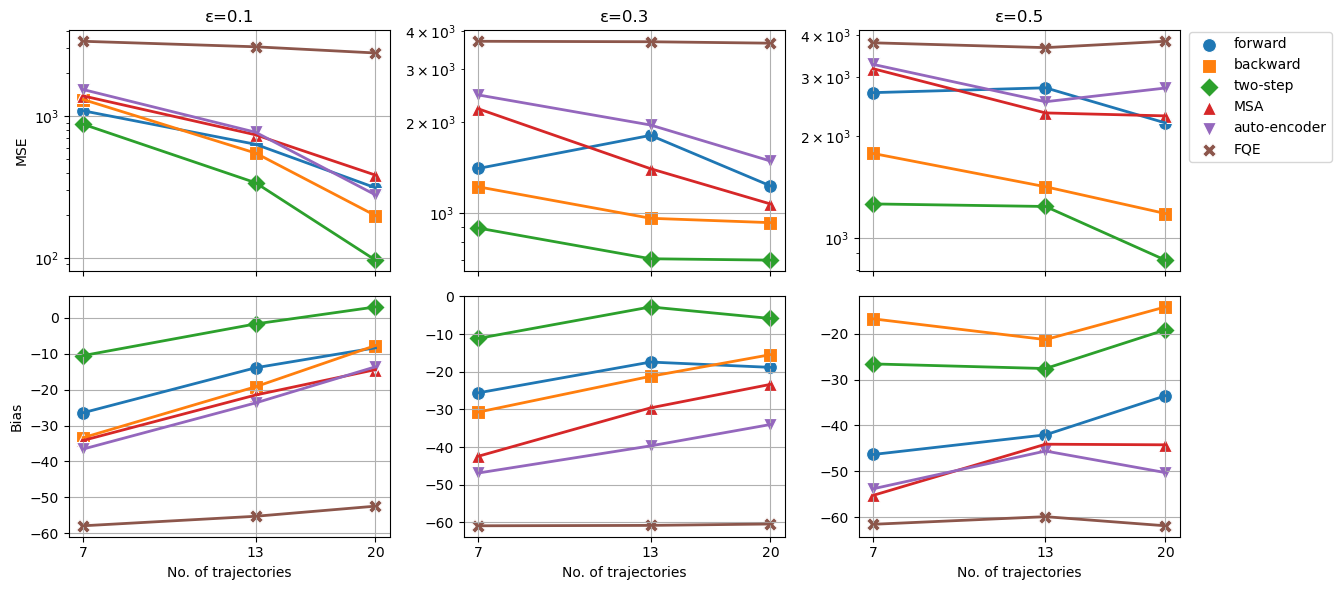

In [18]:
sample_sizes=[7,13,20]
df_mse1, df_bias1 = all_dfs[0]
df_mse3, df_bias3 = all_dfs[1]
df_mse5, df_bias5 = all_dfs[2]

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
seaborn_plot(df_mse1, axes[0,0],"\u03B5=0.1", sample_sizes, ylabel=True, symlog=False)
seaborn_plot(df_bias1, axes[1,0],"\u03B5=0.1", sample_sizes, False, ylabel=True, symlog=False)

seaborn_plot(df_mse3, axes[0,1],"\u03B5=0.3", sample_sizes, symlog=False)
seaborn_plot(df_bias3, axes[1,1],"\u03B5=0.3",sample_sizes,False, symlog=False)

seaborn_plot(df_mse5, axes[0,2], "\u03B5=0.5",sample_sizes, symlog=False)
seaborn_plot(df_bias5, axes[1,2], "\u03B5=0.5",sample_sizes,False, symlog=False)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 0.95))
# Show the plot
plt.tight_layout()
plt.show()